In [0]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


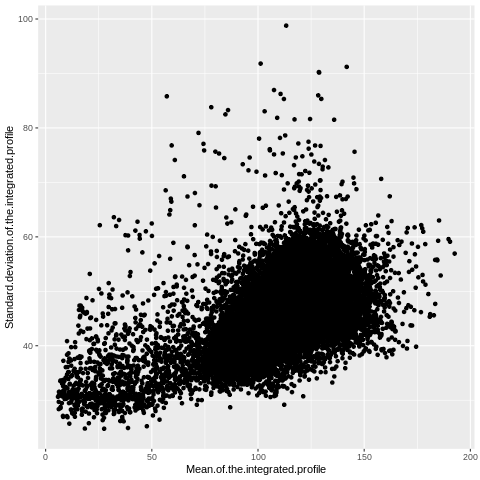

In [0]:
%%R
require(ggplot2)

data <- read.csv('pulsar_stars.csv')

ggplot(data, aes(x = Mean.of.the.integrated.profile, y = Standard.deviation.of.the.integrated.profile) ) +
  geom_point()

In [0]:
%%R
install.packages('GGally')
library(GGally)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/GGally_1.4.0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1051541 bytes (1.0 MB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/d

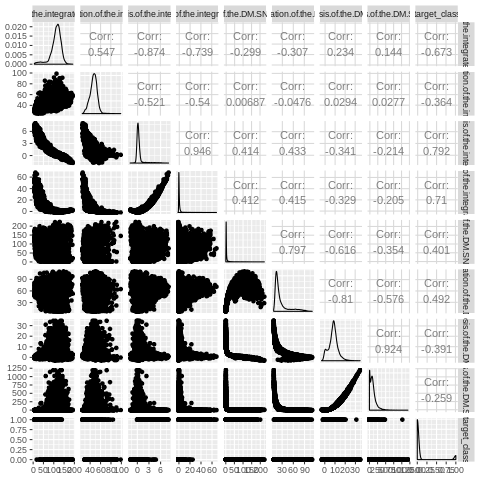

In [0]:
%%R
ggpairs(data)

In [0]:
%%R
cov_mat <- cov(data[-9])


cor(data[-9])

                                             Mean.of.the.integrated.profile
Mean.of.the.integrated.profile                                    1.0000000
Standard.deviation.of.the.integrated.profile                      0.5471369
Excess.kurtosis.of.the.integrated.profile                        -0.8738984
Skewness.of.the.integrated.profile                               -0.7387748
Mean.of.the.DM.SNR.curve                                         -0.2988408
Standard.deviation.of.the.DM.SNR.curve                           -0.3070158
Excess.kurtosis.of.the.DM.SNR.curve                               0.2343312
Skewness.of.the.DM.SNR.curve                                      0.1440330
                                             Standard.deviation.of.the.integrated.profile
Mean.of.the.integrated.profile                                                0.547136926
Standard.deviation.of.the.integrated.profile                                  1.000000000
Excess.kurtosis.of.the.integrated.profile     

In [0]:
data = pd.read_csv('pulsar_stars.csv')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

train_X, test_X = train_test_split(data, train_size = .7)

train_y = train_X.iloc[:,-1]
train_X = train_X.iloc[:,:8]

test_y = test_X.iloc[:,-1]
test_X = test_X.iloc[:,:8]

In [0]:
#Looking at pair plot, these indexes are flipped respective to the output, so we mult by -1. This
#produces significant improvement
for num in [0, 1, 4, 6, 7]:
  train_X.iloc[:,num] *= -1
  test_X.iloc[:,num] *= -1

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)

list(np.mean(col) for col in train_X.T) #show that all col means are 0

[-1.9850730963923617e-16,
 5.169697506747536e-16,
 2.949251457497223e-17,
 -9.074619869222225e-18,
 -6.805964901916668e-18,
 -3.7999970702368064e-17,
 -2.382087715670834e-17,
 -4.253728063697918e-17]

#PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(train_X)

train_X = pca.transform(train_X)

In [0]:
pipe = make_pipeline(scaler, pca)
test_X = pipe.transform(test_X)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(train_X, train_y)

logreg_predict = logreg.predict(test_X)

logreg_error  = confusion_matrix(y_true = test_y, y_pred = logreg_predict)

logreg_error

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[4872,   18],
       [  87,  393]])

#ElasticNet + GridSearchCV

In [0]:
enet = LogisticRegression(penalty = 'elasticnet', class_weight = {0 : 1, 1 : 2.5}, solver = 'saga', max_iter = 500, n_jobs = 10)

param_grid = {
    'l1_ratio' : list(np.arange(start = 0, stop = 1.05, step = .05) )
}

GSCV = GridSearchCV(enet, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = 10)

GSCV.fit(train_X, train_y)

print('--GridSearch Completed. Best params are:')
print(GSCV.best_params_, GSCV.best_score_)
print('\nWeights + Intercept are', GSCV.best_estimator_.coef_, GSCV.best_estimator_.intercept_)

y_pred = GSCV.best_estimator_.predict(test_X)

confusion_matrix(y_pred = y_pred, y_true = test_y)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   15.5s
[Parallel(n_jobs=10)]: Done 105 out of 105 | elapsed:   29.6s finished


--GridSearch Completed. Best params are:
{'l1_ratio': 0.45} 0.9796455938697318

Weights + Intercept are [[ 1.35471038  0.62093361 -0.28931741  1.18010505 -0.89504615 -1.6443298
  -7.46644129 -1.59099357]] [-3.46618503]


array([[4854,   36],
       [  71,  409]])

# Support Vector Machine + GridSearchCV -> .9439/.9852 True Pos/True Neg

In [0]:
#Takes >4 hours to run, so commented out
'''
from sklearn.svm import SVC

param_grid = {
    'C' : list(np.arange(start = .1, stop = 1.1, step = .1) ),
    'kernel' : ['linear', 'rbf', 'poly'],
    'gamma' : list(np.arange(start = .1, stop = 1.5, step = .1) )
}

svc = SVC()

GSCV = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = 10)

GSCV.fit(train_X, train_y)

print(GSCV.best_params_, GSCV.best_score_)

y_pred = GSCV.best_estimator_.predict(test_X)

confusion_matrix(y_pred = y_pred, y_true = test_y)
'''